# Lab 4

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)
hf = h5py.File('../gammaray_lab4.h5', 'r')
hf.keys()

# time (in gps seconds), Solar phase (deg), Earth longitude (deg), and gamma-ray counts
data = np.array(hf.get('data'))
hf.close()

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

__1)__ 

The solar phase and Earth longitude oscillate and do not vary much with time. The number of counts average at around 10 but occasionally spike to a higher/lower number of particles. Looking at plot 5, we can see that there are spikes over a range of solar phase. From homework 3, I could fold the time variable to see if it presents a pattern from the data. With plot 6, there is some no distinct indication of where spikes occur relative to the longitude but do occur more frequently at higher longitudes over the Pacific ocean. Another method is to aggregate the particle counts with a range of solar phase or longitude and compare data within those specific periods. 

__2)__ The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

The background shifts with longitude and solar phase with an increased number of counts at the start of a cycle and then gradually decreases until the next cycle.

__3)__ Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Over the range of 5 to ~352 degree longitude, the average cosmic ray count shifts from 7 to 5.5.

__4)__ Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

100 milliseconds = 100,000 microseconds; time data recorded in microseconds

943271016.0 940680016.0
359.92026748970966 0.03330761316465214
351.6666666666715 5.0


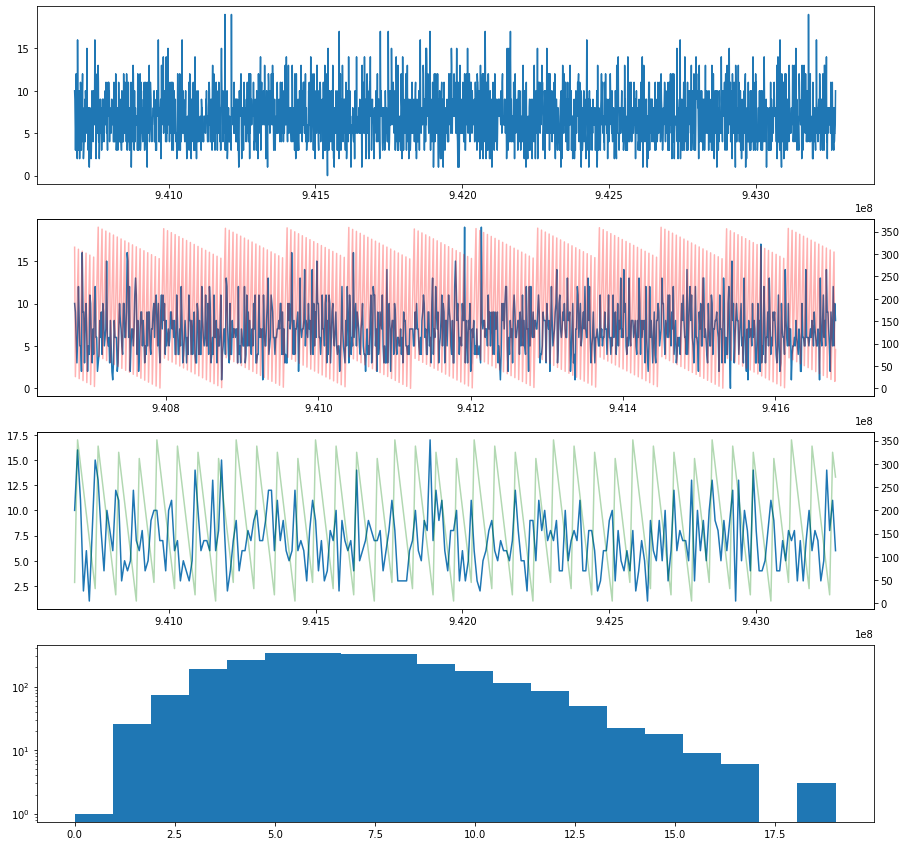

In [3]:
#----- Examining Data
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))

time = data[0][0:-1:10000]
print(np.max(time), np.min(time))
phase = data[1][0:-1:10000]
print(np.max(phase), np.min(phase))
longt = data[2][0:-1:10000]
print(np.max(longt), np.min(longt))
counts = data[3][0:-1:10000]

# ax1.plot(data[0][0:100000:10], data[1][0:100000:10])  # solar phase
# ax2.plot(data[0][0:100000:10], data[2][0:100000:10])  # longitude
ax1.plot(time, counts)

ax2.plot(time[0:1000], counts[0:1000])
temp = ax2.twinx()
temp.plot(time[0:1000], phase[0:1000], 'r', alpha = 0.3)

ax3.plot(time[0:10000:10], counts[0:10000:10])
temp = ax3.twinx()
temp.plot(time[0:10000:10], longt[0:10000:10], 'g', alpha=0.3)

# Does not work as background because there is still noise in this data
ax4.hist(counts, bins=20)
ax4.set_yscale('log', nonposy='clip')

plt.show()

Here we see that the background distribution mostly follows that of a Poisson. This still includes signals so we will now remove them.

In [4]:
#----- Separating Data
##----- Solar Phase grouping
"""
From this initial sample, we can determine the change in time for each minor cycle. Each cycle does not always start at 0 phase as there are major cycles.
We can interpolate the minor cycles and group data by that???
"""
find_solar = np.where(data[1][0:1000000] <= 0.01)[0]

# Get the average differences in time for each minor cycle
delta1 = []
for n in range(len(find_solar)-1):
    diff = find_solar[n+1]-find_solar[n]
    if diff != 1:
        delta1.append(diff)
print(np.average(delta1))
solar_cycle = 50616

##----- Longitude grouping
"""
Similarly, we would want to know for each cycle, how the counts change relative to the satellite's position around the Earth(longitude)
"""
find_longt = np.where(data[2][0:1000000] <= 0.01)[0]  # Arbitrary length; just enough to find a consistent cycle length

delta2 = []
for n in range(len(find_longt)-1):
    diff = find_longt[n+1]-find_longt[n]
    if diff != 1:
        delta2.append(diff)
print(np.average(delta2))
longt_cycle = 53999

50616.31578947369
53999.0


In [10]:
# Separating into single cycles
def reshape(lst, n):
    return [lst[i*n:(i+1)*n] for i in range((len(lst)+n-1)//n)]

# first_solar = 6328
# solar_counts = reshape(data[3][first_solar:200000], solar_cycle)
# solar_time = reshape(data[0][first_solar:200000], solar_cycle)

longt_counts = reshape(data[3][0:-1], longt_cycle)  # Designates the amount of data to be cut into cycles
longt_time = reshape(data[0][0:-1], longt_cycle)

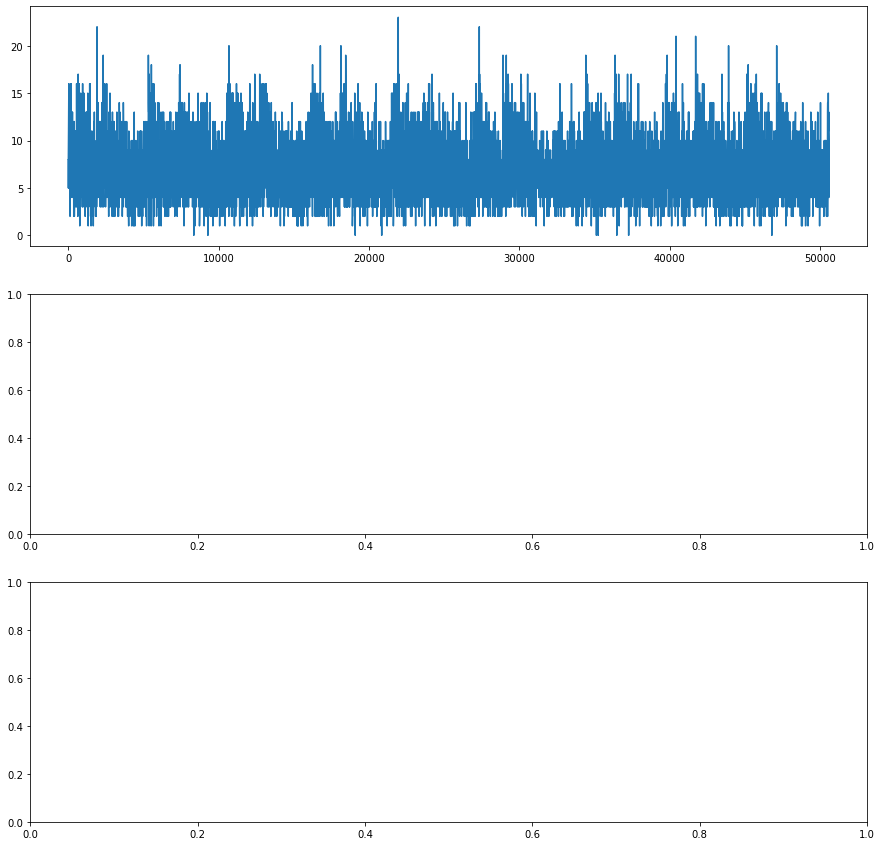

In [11]:
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fold = data[0][0:1000000:100] % 50616
ax1.plot(fold, data[3][0:1000000:100])

# ax2.plot(solar_time[0], solar_counts[0], alpha=0.2)
# ax2.plot(solar_time[1], solar_counts[1], alpha=0.2)
# ax3.hist(solar_counts[0], alpha=0.4, bins=22)
# ax3.hist(solar_counts[1], alpha=0.4, bins=22)

# ax2.plot(longt_time[0], longt_counts[0], alpha=0.3)
# ax2.plot(longt_time[0], longt_counts[1], alpha=0.3)
# ax3.hist(longt_counts[0], bins=22, alpha=0.3)
# ax3.hist(longt_counts[1], bins=22, alpha=0.3)
# ax3.hist(longt_counts[2], bins=22, alpha=0.3)
# ax3.hist(longt_counts[3], bins=22, alpha=0.3)

"""
At this point, we have the cycles, but we want to see the distribution change with time. Thus, we can subdivide the cycles and do a distribution for each 20 degrees longitude.

Before this, we need to eliminate signals. Can compare statistics across all cycles and then isolate signals.

Looking at the histograms, we want to cutoff the right tail at some point to disregard abnormally high count values. We could do this before splicing 20-degree sections.

Actually might be easier to splice first then just cutoff over averaged values and produce the pdf directly from there.
"""
# for n in range(len(longt_counts)-1):
#     ax2.plot(longt_time[0], longt_counts[n], alpha=0.2)
#     ax3.hist(longt_counts[n], bins=22, alpha=0.2)

plt.show()

In [12]:
# Split longitude cycles into 18 20-degree sections
split_ltcounts = []
for n in range(len(longt_counts)):
    split_ltcounts.append(np.array_split(longt_counts[n], 18))  # [[18 sections], [18 sections], [], []]

# Arrange 20-degree longitude sections into groups of corresponding degree
arranged = [[] for n in range(18)]
for n in range(len(longt_counts)):
    for j in range(18):
        arranged[j].append(split_ltcounts[n][j])

# Using average instead of median; assuming enough valid data to not be skewed
combined = [[] for n in range(18)]
for n in range(len(arranged)):
    for j in range(len(arranged[n])):
        combined[n].extend(arranged[n][j])

In [22]:
# Remove data in each section(all cycles) that exceed 5 standard deviations above the mean
for section in combined:
    std = np.std(section)
    avg = np.average(section)
    sig = avg + 5 * std
    for n in section:
        if n > sig:
            section.remove(n)

1439954


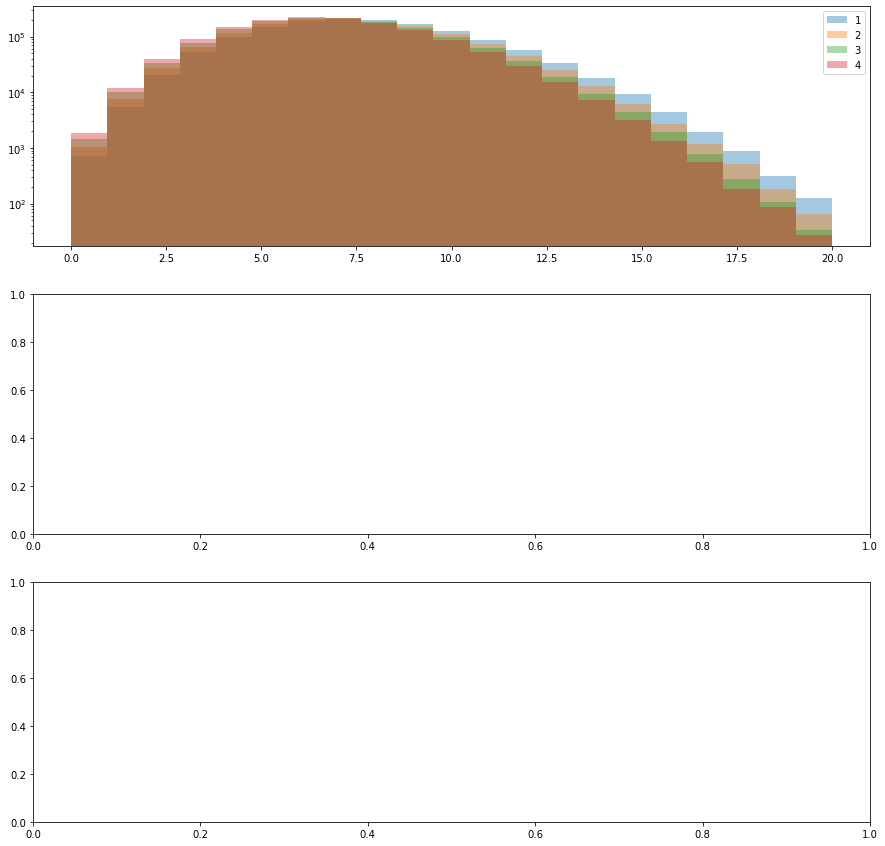

In [34]:
fig3, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

ax1.hist(combined[0], bins=21, alpha=0.4)
ax1.hist(combined[1], bins=21, alpha=0.4)
ax1.hist(combined[2], bins=21, alpha=0.4)
ax1.hist(combined[3], bins=21, alpha=0.4)
ax1.set_yscale('log')
ax1.legend(['1','2','3','4'])

for n in range(len(combined)):
    ax2.hist(combined[n], bins=21, alpha=0.4)
ax2.legend(f)

plt.show()

## Problem 2
- 2 signal searches
- faint star: how to reduce image noise? reduce discovery threshold
- transient: find something in 1 image but not the others; differentiate images
- both: how to get signal-free background for one image; unknown tails in distribution 
- use trials factor??? 
- might not find the signal

Context: stack of 10 telescopes looking at same patch of sky, assume all images is aligned, signal is off

In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

3) Using your background distribution, hunt for your signal (either faint stars, or a __transient__). Describe what you find.

4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)
hf = h5py.File('../images.h5', 'r')
hf.keys()

# time (in gps seconds), Solar phase (deg), Earth longitude (deg), and gamma-ray counts
data = np.array(hf.get('data'))
hf.close()